# Assignment #5 - Deep Learning

### <font color="red"> DUE: Apr 16 (Monday) 11:00 pm </font>  

<font color="blue"> Yangqi Su </font>

# I. Overview
#### Here I will be working with a Pneumonia Dataset from Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
#### The goal at hand is to predict whether a patient has contracted pneumonia with his/her x-ray image

#### to begin, lets import some packages

In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential 
from keras.layers.core import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D
import os
import cv2
import skimage.transform
import time as T
%pylab inline
%matplotlib inline


Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


# II. Data
Dataset Download for Pneumonia Classification:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

The Dataset consists of three folders once unzipped, titled ** Test **, ** Train ** and **Val**. For the purpose of theis assignment, the training data and validation data will be combined into a complete training set. Each folder contains 2 folder **NORMAL** and **PNEUMONIA** respectively. 

 ### Visualization of the images
 

First We read in a single images to get a look at what the data looks like and how to process the data

** image of a bacteria infected patient **

In [2]:
pneumonia_path='./chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg'
normal_path='./chest_xray/train/NORMAL/'

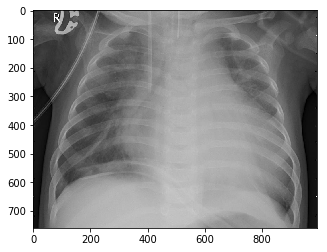

In [3]:
image_test=cv2.imread('./chest_xray/train/PNEUMONIA/person1018_bacteria_2949.jpeg')
plt.imshow(image_test)

** image of a normal patient **

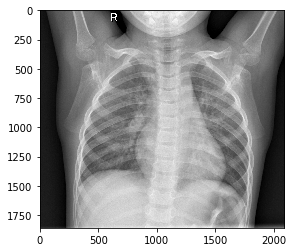

In [4]:
image_test=cv2.imread('./chest_xray/train/NORMAL/IM-0115-0001.jpeg')
plt.imshow(image_test)

** it seems there aren't any noticeable difference between the 2 type of patients **

Perhaps we should be looking at multiple patients between the two conditions

#### With PNEUMONIA

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


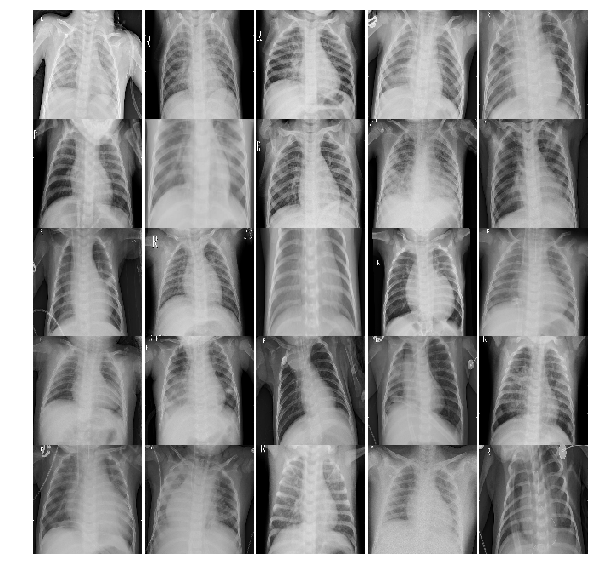

In [5]:

images25 = os.listdir('./chest_xray/train/PNEUMONIA/')[:25]
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for img in images25:
    if img.startswith('.'):
        continue
    im = cv2.imread('./chest_xray/train/PNEUMONIA/'+img)
    im =skimage.transform.resize(im, (128, 128, 3)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(im); 
    plt.axis('off')
    i += 1

### Without PNEUMONIA

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


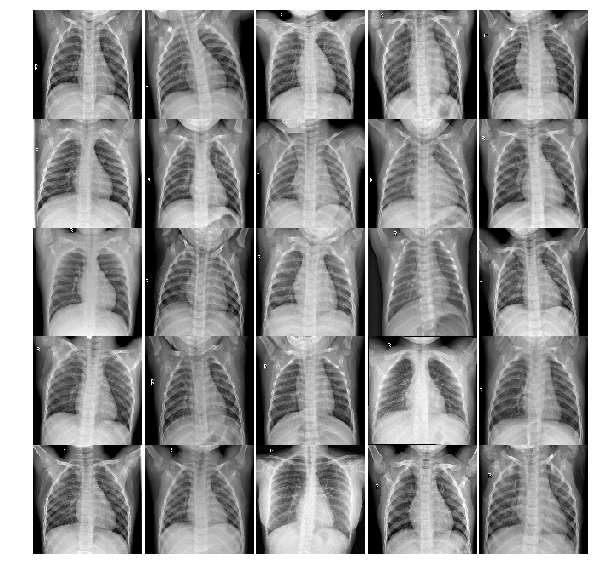

In [6]:
images25 = os.listdir('./chest_xray/train/NORMAL/')[:25]
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for img in images25:
    if img.startswith('.'):
        continue
    im = cv2.imread('./chest_xray/train/NORMAL/'+img)
    im =skimage.transform.resize(im, (128, 128, 3)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(im); 
    plt.axis('off')
    i += 1

** It seems that the biggest difference between the two type of patients is that those with Pneumonia have a fuzzier X-ray image, hopefully the neural network can pick up on that **

Lets look at the image sizes to see if they are the same 

In [21]:
height=[]
width=[]
ratio=[]
for img in os.listdir('./chest_xray/train/NORMAL/'):
    if img.startswith('.'):
        continue
    im= cv2.imread('./chest_xray/train/NORMAL/'+img)
    height.append(im.shape[0])
    width.append(im.shape[1])
    ratio.append(float(im.shape[0])/im.shape[1])
    
for img in os.listdir('./chest_xray/train/PNEUMONIA/'):
    if img.startswith('.'):
        continue
    im= cv2.imread('./chest_xray/train/PNEUMONIA/'+img)
    height.append(im.shape[0])
    width.append(im.shape[1])
    ratio.append(float(im.shape[0])/im.shape[1])
    
for img in os.listdir('./chest_xray/test/PNEUMONIA/'):
    if img.startswith('.'):
        continue
    im= cv2.imread('./chest_xray/test/PNEUMONIA/'+img)
    height.append(im.shape[0])
    width.append(im.shape[1])
    ratio.append(float(im.shape[0])/im.shape[1])
    
for img in os.listdir('./chest_xray/test/NORMAL/'):
    if img.startswith('.'):
        continue
    im= cv2.imread('./chest_xray/test/NORMAL/'+img)
    height.append(im.shape[0])
    width.append(im.shape[1])
    ratio.append(float(im.shape[0])/im.shape[1])
    

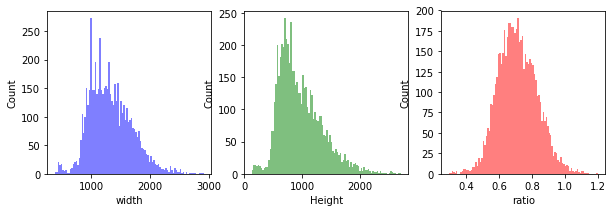

In [32]:
plt.figure(figsize=(10,3))
histo_w = plt.subplot(1,3,1)
histo_w.set_ylabel('Count')
histo_w.set_xlabel('width')
_=plt.hist(width, bins= 100, lw = 0, color='b', alpha=0.5)
histo_h = plt.subplot(1,3,2)
histo_h.set_ylabel('Count')
histo_h.set_xlabel('Height')
_=plt.hist(height, bins= 100, lw = 0, color='g', alpha=0.5)
histo_r = plt.subplot(1,3,3)
histo_r.set_ylabel('Count')
histo_r.set_xlabel('ratio')
_=plt.hist(ratio, bins= 100, lw = 0, color='r', alpha=0.5)

In [33]:
min(width)

384

In [34]:
min(height)

127

In [36]:
min(ratio)

0.29596412556053814

In [37]:
max(ratio)

1.1970443349753694

** In summary **
* the smallest width found for the images was 384 pixels
* the smallest height found for the images was 127 pixels
* the largest height to width ratio was 1.19
* the smallest height to width ratio was 0.29

** Furthermore, a counting of the number of Pneumonia patients vs the number of Normal patients found that the datset was unbalanced, Thus in the following steps the images for training and testing were resized accordingly to preserve a much of the original height to width ratio, and for training images  upsampling was performed for normal patients to counter the imbalance of the dataset **

### preprocessing: 
* Reading in the training and testing Data 
* resizing images to 128x128
* shuffling images
* augmenting dataset for training data

In [7]:
def shuffler(X, T):
    assert X.shape[0] == T.shape[0], 'not the same shape'
    s=np.arange(X.shape[0])
    np.random.shuffle(s)
    return X[s], T[s]

In [8]:
def scaledresize(image, shape, samples=3, fixed_scale=1.2):
    hscale=image.shape[0]/shape[0]
    wscale=image.shape[1]/shape[1]
    scale=min([hscale,wscale])
    newh=int(image.shape[0]//scale)+1
    neww=int(image.shape[1]//scale)+1
    if float(neww)/newh >= fixed_scale or float(newh)/neww >= fixed_scale:
        if float(neww)/newh >= fixed_scale:
            neww=int(newh*fixed_scale)
        else:
            newh=int(neww*fixed_scale)
    img=skimage.transform.resize(image, (newh, neww, image.shape[2]))
    hdiff=newh-shape[0]
    wdiff=neww-shape[1]
    newimgs=[]
    for i in range(samples):
        hstart=np.random.choice(np.arange(hdiff))
        wstart=np.random.choice(np.arange(wdiff))
        newimgs.append(img[hstart:shape[0]+hstart, wstart:shape[1]+wstart,:])
    return newimgs

In [9]:
# path variable should be directories of train, test or val
def readXrayData(path, shape, train=False):
    label={'NORMAL':0, 'PNEUMONIA':1}
    X=[]
    T=[]
    Norm_Num=len(os.listdir(path+"/"+"NORMAL"))
    Sick_Num=len(os.listdir(path+"/"+"PNEUMONIA"))
    SampleNum={'NORMAL':1, 'PNEUMONIA':1}
    if train:
        if Norm_Num > Sick_Num:
            SampleNum['PNEUMONIA']=Norm_Num//SickNum+1
        else:
            SampleNum['NORMAL']=Sick_Num//Norm_Num+1
            
    for file in os.listdir(path):
        if file.startswith('.'):
            continue     
        path_files=os.listdir(path+"/"+file)
        for img in path_files:
            if img.startswith('.'):
                continue
            full_path=path+"/"+file+"/"+img
            image=cv2.imread(full_path)
            #image=cv2.resize(image, dsize=(128, 128, 3), interpolation=cv2.INTER_CUBIC)
            if train:
                image=scaledresize(image, shape, samples=SampleNum[file])
            else:
                image=[skimage.transform.resize(image, shape)]
            for i in range(len(image)):
                X.append(image[i])
                T.append(label[file])
    return shuffler(np.asarray(X), to_categorical(np.asarray(T)))

In [10]:
Xtest, Ttest = readXrayData('./chest_xray/test', shape=(128,128,3))

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [11]:
Xtrain, Ttrain = readXrayData('./chest_xray/train', shape=(128,128,3), train=True)

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [12]:
Xval, Tval = readXrayData('./chest_xray/val', shape=(128,128,3), train=True)

/home/paperspace/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [13]:
Xtrain_all = np.vstack((Xtrain, Xval))
Ttrain_all = np.vstack((Ttrain, Tval))

#### Lets take a look at the new images for training

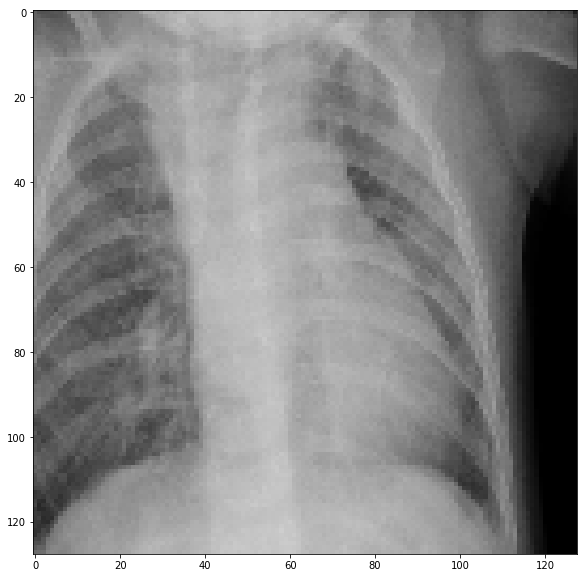

In [43]:
plt.imshow(Xtrain_all[30])

** upon first look, this is fuzzy, so maybe it is a pneumonia patient? **

In [45]:
Ttrain_all[30]

array([ 0.,  1.])

** that is a correct guess! perhaps the resizing and sampling didn't lose important information, BUT we still need to verify with the neural network **

In [47]:
Ttrain_all.shape[0]

7922

In [48]:
Xtrain_all.shape

(7922, 128, 128, 3)

There are now 7922 samples after sampling, the image shapes are all **128**x**128**x**3**

# III. Methods

In this assignment, you are build a deep network with more than 5 layers using TensorFlow. 
Looking at the chart below, get some idea about how you can construct your networks for what problem and why you pick your structure. 

- Pick at least 3 different networks for experiments.
- Summarize the choice of your networks. 
- Explain your TensorFlow codes. 
- Explain how you apply your model to your data. 

Following images are only for you to get some idea. You do not necessarily stick with these. You can come up with your own structure or shape. 

![](https://camo.githubusercontent.com/31e20172e3b7bc5530a6e7c7e7339e8e556d0acc/687474703a2f2f7777772e6173696d6f76696e737469747574652e6f72672f77702d636f6e74656e742f75706c6f6164732f323031362f30392f6e657572616c6e6574776f726b732e706e67)



## TRAINING:
#### Three Convolutional Neural Networks with Different Structures in the Convolution Layers (similar amount of paramters)
#### Convolutional Neural Nets were chosen because they work well on images as the convolution operation can be used to learn features from iamges in the past. 
#### Steps for Each Model:
* clearing the previous session, so not to run into OOM error when training this model
* initialize a Sequential object from keras.layers to add in different layers
* add in ** 3 ** Convolutional2D layers
* add in Dropout and MaxPooling2D layers after final Conv2d layers
* Flatten Final output of Conv2D layer and feed into 2 layers of Fully Connected Layers
* Output into layer with 2 units that represent the target category

### MODEL 1:
**REASONING: obeserve the effect of increasing kernel number through the Convolution layers **

** Hypothesis: the features learned through different CNN layers are combined into various higher features, which means the number of kernels should increase **

** 3 layers of Convolution: **
* kernel num = [32, 64, 128, 128]
* kernel size = [3, 3]


** 2 layers of Dense:  **
* hidden units [128, 256]

In [68]:
def model1():
    model_1 = Sequential() 
    model_1.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
    model_1.add(Conv2D(32, kernel_size=(3, 3), activation='relu')) 
    model_1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model_1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model_1.add(Dropout(0.5)) 
    model_1.add(MaxPooling2D(pool_size = (2, 2)))
    model_1.add(Flatten())
    model_1.add(Dense(128, activation='relu')) 
    model_1.add(Dense(1024, activation='relu'))
    model_1.add(Dropout(0.5)) 
    model_1.add(Dense(2, activation='softmax'))    
    return model_1

### MODEL 2:
**REASONING: obeserve the effect of Decreasing kernel number through the Convolution layers **

**Hypothesis: the kernels in the layers gradually learn better abstract representations of the images, thus the number of kernels should decrease**

** 3 layers of Convolution: **
* kernel num = [128, 64, 32, 128]
* kernel size = [3, 3]


** 2 layers of Dense:  **
* hidden units [128, 256]

In [67]:
def model2():
    model_2 = Sequential() 
    model_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
    model_2.add(Conv2D(32, kernel_size=(3, 3), activation='relu')) 
    model_2.add(Conv2D(16, kernel_size=(3, 3), activation='relu')) 
    model_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model_2.add(Dropout(0.5)) 
    model_2.add(MaxPooling2D(pool_size = (2, 2)))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu')) 
    model_2.add(Dense(1024, activation='relu'))
    model_2.add(Dropout(0.5)) 
    model_2.add(Dense(2, activation='softmax'))
    return model_2

### MODEL 3:
**REASONING: obeserve the effect of decreasing followed by increasing (bottlenecking) kernel number through the Convolution layers **

** Condensing the layers in to latent features before re-expanding them, kind of like a auto-encoder **

** 3 layers of Convolution: **
* kernel num = [64, 16, 64, 128]
* kernel size = [3, 3]


** 2 layers of Dense:  **
* hidden units [128, 256]

In [66]:
def model3():
    model_3 = Sequential() 
    model_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
    model_3.add(Conv2D(16, kernel_size=(3, 3), activation='relu')) 
    model_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) 
    model_3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model_3.add(Dropout(0.5)) 
    model_3.add(MaxPooling2D(pool_size = (2, 2)))
    model_3.add(Flatten())
    model_3.add(Dense(128, activation='relu')) 
    model_3.add(Dense(1024, activation='relu'))
    model_3.add(Dropout(0.5)) 
    model_3.add(Dense(2, activation='softmax'))
    return model_3

# IV - Results

- Presents the results of applications of your deep networks.
- Visualize the results 
- Discuss about the choice of network structures and performance of it as you change the structures.  
- What do you think about the results? 

** Applying early stopping for network training based on validation accuracy **

In [85]:
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=6, verbose=1, mode='auto')
callbacks_list = [earlystop]

**MISC Functions for plotting Training History**

In [ ]:
def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(history.history['acc'])+1),history.history['acc'])
    axs[0].plot(range(1,len(history.history['val_acc'])+1),history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history.history['acc'])+1),len(history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

** Show the results of 10 predictions on the test dataset **

In [28]:
def show10Predictions(model, Xtest, Ttest):
    predictions = model.predict(Xtest)
    plt.figure(figsize=(15, 15)) 
    for i in range(10):    
        ax = plt.subplot(2, 10, i + 1)    
        plt.imshow(Xtest[i, :, :, 0], cmap="gray")    
        plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Ttest[i]), np.argmax(predictions[i])))    
        plt.axis('off') 
    plt.show()

** drawing the ROC curve using sklearn functions **

In [47]:
from sklearn.metrics import roc_curve, auc
def roc_auc(model, X, T):
    fpr, tpr, _ =roc_curve( np.argmax(T, axis=1), model.predict(X)[:, 1])
    roc_auc=auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show() # Code from sklearn tutorial for plotting of auc roc curves

### MODEL 1 RESULTS:

In [69]:
K.clear_session()
model_1=model1()
start_time=T.time()
model_1.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
model_1.summary()
history_1 = model_1.fit(Xtrain, Ttrain, batch_size=50, callbacks=callbacks_list,epochs=40, verbose=2, validation_split=0.2) 
score = model_1.evaluate(Xtest, Ttest, verbose=0)
print('Accuracy:', score[1])
print('Time used (seconds) for GPU training for '+str(history_1.epoch[-1])+ 'epochs: '+str(T.time()-start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 120, 120, 128)     73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 120, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 460800)            0         
__________

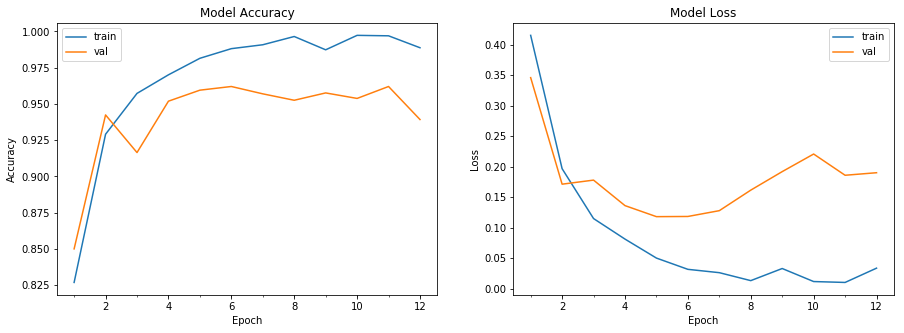

In [70]:
plot_model_history(history_1)

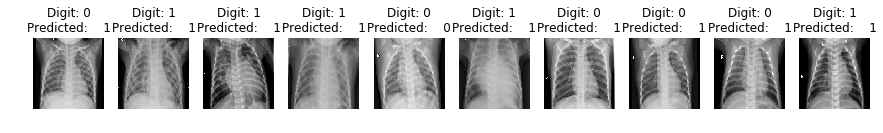

In [71]:
show10Predictions(model_1, Xtest[25:35], Ttest[25:35])

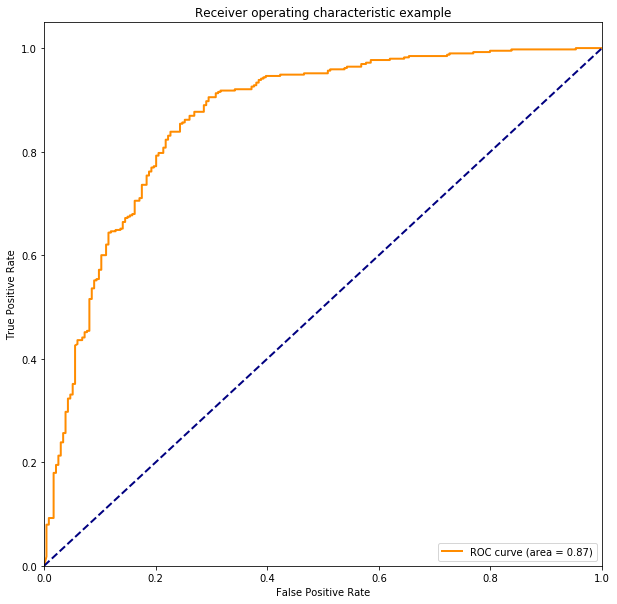

In [72]:
roc_auc(model_1, Xtest, Ttest)

### MODEL 2 RESULTS:

In [83]:
K.clear_session()
model_2=model2()
model_2.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
model_2.summary()
history_2=model_2.fit(Xtrain, Ttrain, batch_size=50, callbacks=callbacks_list, epochs=40, verbose=2, validation_split=0.2) 
score = model_2.evaluate(Xtest, Ttest, verbose=0)
print('Accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 32)      18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 16)      4624      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 120, 120, 128)     18560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 120, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 460800)            0         
__________

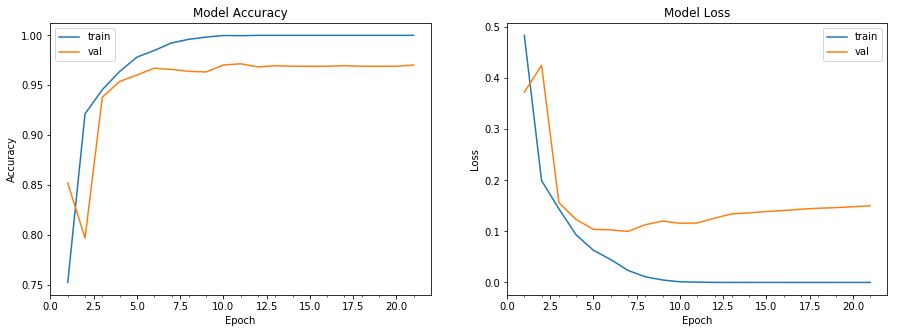

In [86]:
plot_model_history(history_2)

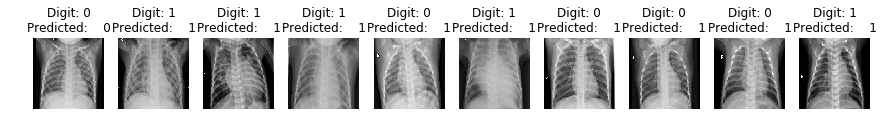

In [87]:
show10Predictions(model_2, Xtest[25:35], Ttest[25:35])

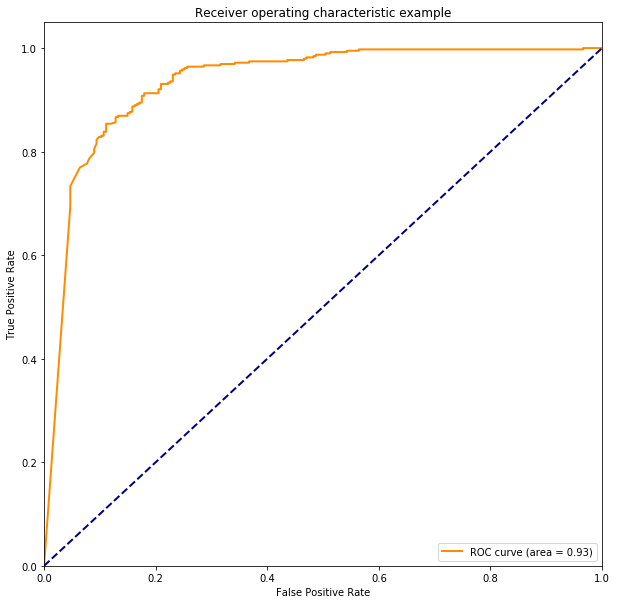

In [88]:
roc_auc(model_2, Xtest, Ttest)

### MODEL 3 RESULTS:

In [73]:
K.clear_session()
model_3=model3()
model_3.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
model_3.summary()
history_3=model_3.fit(Xtrain, Ttrain, batch_size=50, callbacks=callbacks_list, epochs=40, verbose=2, validation_split=0.2) 
score = model_3.evaluate(Xtest, Ttest, verbose=0)
print('Accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 16)      9232      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 64)      9280      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 120, 120, 128)     73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 120, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 460800)            0         
__________

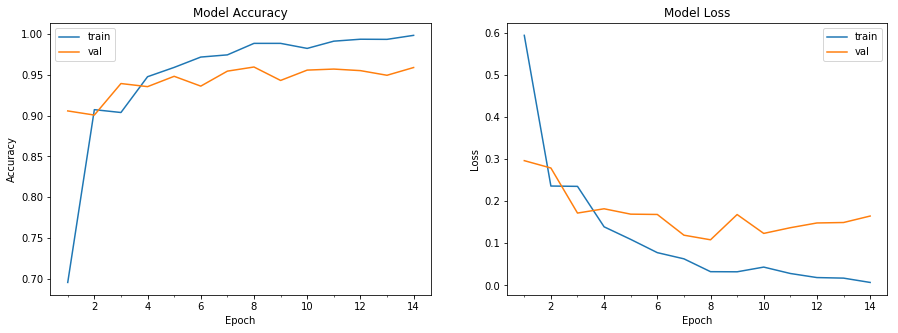

In [74]:
plot_model_history(history_3)

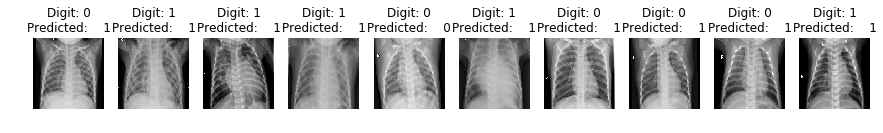

In [76]:
show10Predictions(model_3, Xtest[25:35], Ttest[25:35])

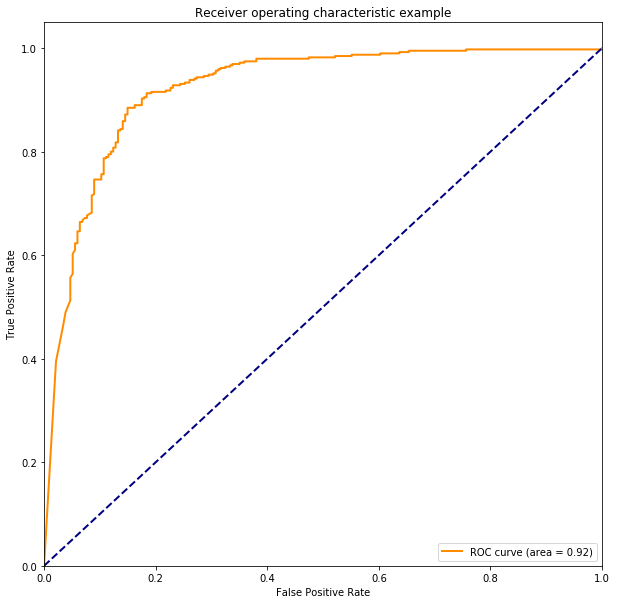

In [77]:
roc_auc(model_3, Xtest, Ttest)

** The results from the three different models were not that different, however it can be seen that the bottelnecked model produced the best result (though under different runs, the results weren't that different). It is possible that under the same of amount of parameters, the bottlenecked model was able to map the images to latent feature representations that better generalized the differences between PNEUMONIA and NORMAL patients. Also, from the results on Model 2, it can be seen in the later epochs the model started to overfit, as the training accuracy was at 100%, the validation accuracy began to drop since it could not generalize to the unseen data, however its predictions were still on par with that of model 3 and yielding a higher AUC score**

#### Finally, all 3 models' predictions on randmly chosen 10 images above showed that they are tend to predict NORMAL as PNEUMONIA patients, this is understandable as the number of True PNEUMONIA patients is greater than that of the NORMAL patients.

# Conclusions
Building Different Deep learning Structures is simple using Keras, however, it is hard to know which structure will produce the best results. Using early stopping with training can prevent overfitting in later epochs as training accuracy gets closer to 100%, also dataset size and balance is of much importance. Furthermore, it is even more difficult to interpret the network structures and the meaning of the weights and kernels in the structures.

# Extra Credit
#### All models above were trained with P4000 GPU on Paperspace's cloud GPUs, and 10 epochs generally take around 4 minutes to finish 

#### Now I will perform training on the first model for 1 epoch (since it really takes a long time) as a comparison for the speedup given by GPUs.

In [95]:
import time as T
start_time=T.time()
K.clear_session() 
model_cpu = Sequential() 
model_cpu.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model_cpu.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) 
model_cpu.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) 
model_cpu.add(Dropout(0.5)) 
model_cpu.add(MaxPooling2D(pool_size = (2, 2)))
model_cpu.add(Flatten())
model_cpu.add(Dense(128, activation='relu')) 
model_cpu.add(Dense(256, activation='relu'))
model_cpu.add(Dropout(0.5)) 
model_cpu.add(Dense(2, activation='softmax'))
model_cpu.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history_cpu = model_cpu.fit(Xtrain, Ttrain, batch_size=50, epochs=1, verbose=2, validation_split=0.2) 
score = model_cpu.evaluate(Xtest, Ttest, verbose=0)
print('Accuracy:', score[1])
print('Time used (seconds) on CPU for 1 epoch: '+str(T.time()-start_time))

Train on 6318 samples, validate on 1580 samples
Epoch 1/1
 - 39s - loss: 0.4274 - acc: 0.8386 - val_loss: 0.2350 - val_acc: 0.8956
Accuracy: 0.836538461538
Time used (seconds) on CPU for 1 epoch: 834.7950751781464


## Grading

DO NOT forget to submit your data! Your notebook is supposed to run fine after running your codes. 


points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
15 | Data | 
 | 5| Includes description of your data
 | 5| Plots to visualize data 
 | 5| Reading and analyzing the plots 
50 | Methods | 
 | 30| Explanation of the choice for 3 different neural network structures and reason for the selection. (10 points for each) 
 |   | Relate the choice of your data!
 | 15| Explanation of codes for each structure
 |  5| Explanation of experimental codes
25 | Results | Your Data
| 15| plots for results 
| 10| Discussions about the choice of network structures 
5 | Conclusions 
